In [23]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'H':0, 'D':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        #self.hiddensCount = 2
       
        
    def readFootBallData(self,filename): 
        df = pd.read_csv(filename)
        df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
        df['HTR'] = df['HTR'].map(self.win_mapping)
        df['FTR'] = df['FTR'].map(self.win_mapping)
        df= df.drop('Referee', 1)
        print(df.shape)
          #self.team = df['HomeTeam'].drop_duplicates()
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
 
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
    def formatData(self, X_train ):
        print("start format")
        X_train = X_train.sort_values(by="Date")
        X_train['Date'] = pd.to_numeric(X_train['Date'])/1e9/24/60/60
        
        sys.stdout.flush()
        res = []
        y =[]
        for v in X_train['FTR']:
            y.append(range(3)==v)
        resy=[]
        for i in range(X_train.shape[0]):
            print("\r progress {}".format(i))
            sys.stdout.flush()
            x = X_train.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeTeam = self.getTeam(X_train,homeName)
            awayTeam = self.getTeam(X_train,awayName)
            prevHome = self.previousRecords(homeTeam,x['Date'])
            prevAway = self.previousRecords(awayTeam,x['Date'])
            if prevHome is None or prevAway is None:
               # print("{} skip".format(i))
                continue
           # print("{} has enough sample".format(i))  
            prevHome=prevHome.copy()
            prevAway = prevAway.copy()
            prevHome['HomeTeam']=(prevHome['HomeTeam']==homeName)
            prevHome['AwayTeam']=(prevHome['AwayTeam']==homeName)
            prevAway['HomeTeam']=(prevAway['HomeTeam']==awayName)
            prevAway['AwayTeam']=(prevAway['AwayTeam']==awayName)
            homeDate = prevHome['Date'].values
            awayDate = prevAway['Date'].values
            #homeDate = homeDate.astype('uint64')/1e9/24/60/60
            homeDate = x['Date'] - homeDate 
            #awayDate = awayDate.astype('uint64')/1e9/24/60/60
            awayDate = x['Date'] - awayDate 
            #print(homeDate)
            hv = prevHome.drop('Date',axis=1).values
            av = prevAway.drop('Date',axis=1).values
            hv = np.column_stack([hv, homeDate])
            av = np.column_stack([av,awayDate])
            
            inData = np.ravel(np.array([hv,av]))
            res.append(inData)
            resy.append(y[i])
        
        Xres = np.array(res)
        
       
        X_train_std = Xres
        print("finish")

        return (X_train_std,np.array(resy))
            
    def fit(self,X=None,y=None):
        teams = self.df['HomeTeam'].drop_duplicates()
       
        if X is None or y is None:
            (X, y)=self.formatData(df)
        X_train,X_test_val, y_train, y_test_val =    train_test_split(X,y, test_size=0.4)
        X_val ,X_test,y_val,y_test = train_test_split(X_test_val,y_test_val, test_size=0.5)
        print(X_val)
        
        
     
        print("Start Training")
        self.nn.fit(X_train,y_train)
        print("fisish Training")
        return (X_val ,X_test,y_val,y_test)

    def validate(self, X_val, y_val):
            return self.nn.predict(X_val)
            
            
        
        
    def previousRecords(self,team, date , recentNum):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-recentNum:]
    def readPredict (self, filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
        df['FTR'] = df['FTR'].map(self.win_mapping)
        return df
    
    def getH1(self):
        #recent matches (only win/loss/draw)
       
        
       # print (self.df)      
        X  = self.df.sort_values(by="Date")
        y = []
        for v in X['FTR']:
            y.append(range(3)==v)
       # print(y)
        resy=[]
        resx=[]
        print("h1:start format")
        for i in range(X.shape[0]):
            
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            x = X.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeTeam = self.getTeam(X,homeName)
            awayTeam = self.getTeam(X,awayName)
            prevHome = self.previousRecords(homeTeam,x['Date'])
            prevAway = self.previousRecords(awayTeam,x['Date'])
            if prevHome is None or prevAway is None:
               # print("{} skip".format(i))
                continue
            prevHomeWin = []
            prevAwayWin = []
            for v in prevHome['FTR']:
                prevHomeWin.append(range(3) == v)
            #print(prevHomeWin)
            for v in prevAway['FTR']:
                prevAwayWin.append(range(3) == v)
            pHHT=(prevHome['HomeTeam']==homeName).values
            pAHT=(prevAway['HomeTeam']==awayName).values
            tempX=[]
            for j in range(pHHT.shape[0]):
                tempX.append(np.append(prevHomeWin[j],pHHT[j]))
                
            for j in range(pAHT.shape[0]):
                tempX.append(np.append(prevAwayWin[j],pAHT[j]))
            resx.append(np.ravel(tempX))
            
            resy.append(y[i])
        print("finish")
        sys.stdout.flush()
        return np.array(resx), np.array(resy)
    def getH2(self):         
       #team based      
        X  = self.df.sort_values(by="Date")
        y = []
        for v in X['FTR']:
            y.append(range(3)==v)
       # print(y)
        resy=[]
        resx=[]
        print("h1:start format")
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        nativeX = X[['HomeTeam','AwayTeam']].values
        #print(X)
        ohe = OneHotEncoder(categorical_features=[0,1])
        res = ohe.fit_transform(nativeX).toarray()
        #print(res)
        return res, np.array(y)
    def _getH3RecentMatches(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = self.previousRecords(team,x['Date'],recentNum)
        if prev is None:
               return None
        prevHt=  prev['HomeTeam'].values
        prevAt=  prev['AwayTeam'].values   
        prevIsHome = []
        prevOther = []
        for i in range(recentNum):
            if prevHt[i] == teamName:
                prevIsHome.append(1)
                prevOther.append(prevAt[i])
            else:
                prevIsHome.append(0)
                prevOther.append(prevHt[i])
        wins = prev['FTR'].values       
        temp = np.array([prevIsHome,prevOther,wins]).T

        return np.ravel(temp)
        
    def getH3(self, recentNum):
        X  = self.df.sort_values(by="Date")
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        y = []
        for v in X['FTR']:
            y.append(range(3)==v)
       # print(y)
        resy=[]
        resx=[]
        print("h3:start format")
        recents = []
        for i in range(X.shape[0]):
            
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            x = X.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeRecent = self._getH3RecentMatches(x,X,homeName, recentNum)
            awayRecent =self._getH3RecentMatches(x,X,awayName, recentNum)
            if homeRecent is None or awayRecent is None:
                   continue 
        #    print(homeName)
         #   print(homeRecent)
        #    print(awayName)
         #   print(awayRecent)
         #   return
            recents.append(np.hstack([homeName,awayName, homeRecent,awayRecent]))        
            resy.append(y[i])
        cols =np.hstack([[0,1],list(range(3,len(recents[0]),3))])
        print(cols)
        ohe = OneHotEncoder(categorical_features=cols)
        res = ohe.fit_transform(recents).toarray()
        print("finish")
        sys.stdout.flush()
        return res, np.array(resy)
   

    def getH4(self, recentNum, target=None):
        
        X  = self.df.sort_values(by="Date")
        isInput = False
        if target is None:
            target =X      
        else:
            if self.ohe is None:
                raise Exception("Not yet get train data")
            isInput = True
            target['HomeTeam']=target['HomeTeam'].map(self.teamsMap)
            target['AwayTeam']=target['AwayTeam'].map(self.teamsMap)
            pass
            
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        target_date = (pd.to_numeric(target['Date'])/1e9/24/60/60).values
        y = []
        for v in target['FTR']:
            y.append(range(3)==v)
       # print(y)
        resy=[]
        resx=[]
        print("h4:start format")
        recents = []
        for i in range(target.shape[0]):
            
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            x = target.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeRecent = self._getH3RecentMatches(x,X,homeName, recentNum)
            awayRecent =self._getH3RecentMatches(x,X,awayName, recentNum)
            if homeRecent is None or awayRecent is None:
                   continue 
           # print(homeName)
           # print(homeRecent)
          #  print(awayName)
            #print(awayRecent)
            if recentNum == 0:
                recents.append(np.hstack([homeName,awayName,target_date[i]]))
            else:
                recents.append(np.hstack([homeName,awayName,target_date[i], homeRecent,awayRecent]))            
            resy.append(y[i])
#        print(recents)
        if isInput==False:
            cols = None
            if recentNum == 0 :
                cols = np.array([0,1])
            else:
                cols =np.hstack([[0,1],list(range(4,len(recents[0]),3))])
            self.ohe = OneHotEncoder(categorical_features=cols)
            self.ohe.fit(recents)

        res = self.ohe.transform(recents).toarray()
        print("finish")
        sys.stdout.flush()
        return res, np.array(resy)

In [24]:

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]

def firstNScore(n, pred, y):
    for r in range(pred.shape[0]):
        row = pred[r]
        s = np.sort(row)
        for c in range(pred.shape[1]):
            temp = pred[r][c]
            pred[r][c] = False
            for j in range(1,n+1):
                if temp == s[-j]:
                    pred[r][c] = True
                    break
    res = np.sum(np.logical_and(pred,y))/pred.shape[0]
    return res               
        
    

In [25]:
c = FootballDataHelper(recentNum=4)
c.readFootBallData("E0_1314.csv")
c.readFootBallData("E0_1415.csv")
c.readFootBallData("E0 (1).csv")
print(c.teamsMap)

(380, 21)
(380, 21)
(293, 21)
{'Newcastle': 14, 'Leicester': 20, 'Aston Villa': 10, 'QPR': 21, 'Watford': 24, 'Swansea': 4, 'Sunderland': 3, 'Stoke': 16, 'Tottenham': 18, 'Man City': 9, 'Everton': 11, 'Man United': 19, 'Chelsea': 7, 'West Ham': 6, 'Cardiff': 17, 'Southampton': 15, 'Fulham': 12, 'West Brom': 5, 'Crystal Palace': 8, 'Liverpool': 1, 'Bournemouth': 23, 'Burnley': 22, 'Norwich': 2, 'Arsenal': 0, 'Hull': 13}


In [26]:

#alpha, hidden size, score, weighted Score

#c.fit()
#c.fit()
#X, y = c.formatData(c.df)
#print(X)
X,y = c.getH4(4)
#X, y =c.getH3(5)


h4:start format
 progress 1052finish


In [27]:
inData = c.readPredict("predict.csv")
print(inData)
X_in, y_in = c.getH4(4,target=inData)
print(y_in)


        Date     HomeTeam     AwayTeam  FTR
0 2016-03-12      Norwich     Man City    1
1 2016-03-12  Bournemouth      Swansea    0
2 2016-03-12        Stoke  Southampton    2
3 2016-03-14  Aston Villa    Tottenham    2
4 2016-03-15    Leicester    Newcastle    0
h4:start format
 progress 4finish
[[False  True False]
 [ True False False]
 [False False  True]
 [False False  True]
 [ True False False]]


In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
hiddenNodes = int(12)
print(hiddenNodes)
clf = SoftMaxMLPClassifier(hidden_layer_sizes=[hiddenNodes], activation='logistic', algorithm='l-bfgs', alpha=50, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=1000,early_stopping = True,verbose = 3)
mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])

12


In [29]:
mlp.fit(X,y)
#res = mlp.predict(X_in)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=50,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=True, epsilon=1e-08, hidden_layer_sizes=[12],
           learn...e=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False))])

In [30]:
print(X.shape)
print(X_in.shape)
res = mlp.predict(X_in)
print(res)
proba= mlp.predict_proba(X_in)
print(y_in)
print(mlp.score(X_in,y_in))
print(proba)
print(firstNScore(2,proba,y_in))

(993, 267)
(5, 267)
[[False False  True]
 [ True False False]
 [False False  True]
 [False False  True]
 [ True False False]]
[[False  True False]
 [ True False False]
 [False False  True]
 [False False  True]
 [ True False False]]
0.8
[[ 0.18845696  0.21467054  0.5968725 ]
 [ 0.67735162  0.16321294  0.15943545]
 [ 0.25909715  0.20545068  0.53545217]
 [ 0.35779591  0.18831749  0.4538866 ]
 [ 0.66308908  0.16588589  0.17102503]]
1.0


In [32]:
#future
inData = c.readPredict("future.csv")
print(inData)
X_in, y_in = c.getH4(4,target=inData)
res = mlp.predict(X_in)
proba= mlp.predict_proba(X_in)
print ("{}\n{}".format(res,proba))

        Date        HomeTeam     AwayTeam  FTR    HO    DO    AO
0 2016-03-19         Everton      Arsenal    1  2.45  3.35  2.45
1 2016-03-19         Chelsea     West Ham    1  1.57  3.65  4.90
2 2016-03-19  Crystal Palace    Leicester    1  2.83  3.15  2.25
3 2016-03-19         Watford        Stoke    1  2.10  3.00  3.30
4 2016-03-19       West Brom      Norwich    1  2.15  3.00  3.15
5 2016-03-19         Swansea  Aston Villa    1  1.54  3.60  5.35
h4:start format
 progress 5finish
[[False False  True]
 [ True False False]
 [False False  True]
 [ True False False]
 [ True False False]
 [ True False False]]
[[ 0.18762952  0.22318651  0.58918397]
 [ 0.8517382   0.09704269  0.05121911]
 [ 0.29825403  0.20268259  0.49906338]
 [ 0.42604514  0.19004408  0.38391078]
 [ 0.47116997  0.19474191  0.33408812]
 [ 0.60173609  0.18333453  0.21492937]]


In [24]:
mlp.score(X,y)
print(np.sum(np.argmax(res,axis=1) == np.argmax(y,axis=1)))
print(y.shape[0])

434
973


In [ ]:
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 4), 
                      cv=4,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('x_range')
    plt.ylabel('Accuracy')
    plt.show()



In [ ]:
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)

In [115]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y, fold = 10):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    firstNScores = []
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        firstNScores.append(firstNScore(2, mlp.predict_proba(X[test]), y[test]))
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
    return train_scores,scores, firstNScores



In [62]:
def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        clf.set_params(alpha= lamda)
        print(mlp.get_params())
        train_s, test_s = crossValidate(mlp,X,y,fold=5)
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plotCurve(train_mean,train_std,test_mean,test_std,lamdas)
    return np.array(train_scores),np.array(test_scores)

l_range = np.array(range(10,100,2))
train_scores,test_scores = lamda_test(mlp,X,y,l_range)
#50

{'clf__warm_start': False, 'clf__beta_2': 0.999, 'clf__batch_size': 'auto', 'clf__early_stopping': True, 'clf__algorithm': 'l-bfgs', 'clf__nesterovs_momentum': True, 'clf': SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=10,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=True, epsilon=1e-08, hidden_layer_sizes=[12],
           learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
           momentum=0.9, nesterovs_momentum=True, power_t=0.5,
           random_state=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False), 'clf__shuffle': True, 'clf__learning_rate_init': 0.01, 'clf__activation': 'logistic', 'scl__with_std': True, 'clf__tol': 0.0001, 'clf__random_state': None, 'scl__copy': True, 'clf__epsilon': 1e-08, 'clf__hidden_layer_sizes': [12], 'scl__with_mean': True, 'clf__max_iter': 500, 'clf__momentum': 0.9, 'scl': StandardScaler(copy=True, with_mean=True, with_std=True), 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


#plotCurve(train_mean,train_std,test_mean,test_std,l_range)
plt.plot(l_range, train_mean, 
        color='blue', marker='o', 
        markersize=5, 
        label='training accuracy')
plt.fill_between(l_range, 
              train_mean + train_std,
               train_mean - train_std, alpha=0.15, color='blue')

plt.plot(l_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(l_range, 
                  test_mean + test_std,
                 test_mean - test_std, 
                alpha=0.15, color='green')
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()


In [58]:
from sklearn.cross_validation import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size =0.3)



In [59]:
mlp.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=50,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=True, epsilon=1e-08, hidden_layer_sizes=[12],
           learn...e=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False))])

In [60]:
res = mlp.predict_proba(X_test)


In [63]:
predicted = mlp.predict(X_test)
print(mlp.score(X_test, y_test))
proba = mlp.predict_proba(X_test)

print(firstNScore(2,proba,y_test))

0.47602739726
0.770547945205


In [ ]:
likehoodScore(res,y_test)

In [ ]:
home_teams_test = np.argmax(X_test[:,0:len(c.teamsMap)],axis=1)
away_teams_test = np.argmax(X_test[:,len(c.teamsMap):len(c.teamsMap)*2],axis=1)
inverseMap ={}
for name in c.teamsMap.keys():        
    inverseMap[c.teamsMap[name]] = name

home_name =[]
away_name =[]
for i in range(home_teams_test.shape[0]):         
    home_name.append(inverseMap[home_teams_test[i]])
    away_name.append(inverseMap[away_teams_test[i]])
pre_y = np.argmax(predicted,axis=1)
real_y = np.argmax(y_test,axis=1)
for i in range(predicted.shape[0]):
    if pre_y[i] != real_y[i]:
        print('-------------')
        print("{} vs {}".format(home_name[i],away_name[i]))
        print("{} vs {}".format(res[i],y_test[i]))
    

In [ ]:
#c.df[(c.df['HomeTeam'] == 'West Brom') | (c.df['AwayTeam']=='West Brom')]

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testNodeSize(start ,end):
    node_range = range(start,end,25)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    for node in node_range:   
        print("start node:{}".format(node))
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[node], activation='logistic', algorithm='l-bfgs', alpha=30, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores = crossValidate(mlp,X,y,fold=5)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        print("Node {}: train_mean {}  v.s. test_mean {}".format(node,np.mean(train_scores),np.mean(test_scores)))
    plotCurve(train_means,train_std,test_means,test_std,node_range)
    return train_means,train_std,test_means,test_std

In [ ]:
train_means,train_std,test_means,test_std=testNodeSize(10 , X.shape[1])

In [117]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testRecentNum(start, end):
    recent_range = range(start,end)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    first2_mean=[]
    for recent in recent_range:
        print("start recent:{}".format(recent))
        X,y = c.getH4(recent)
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[12], activation='logistic', algorithm='l-bfgs', alpha=30, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores, first2 = crossValidate(mlp,X,y,fold=10)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        first2_mean.append(np.mean(first2))
        print("recent {}: train_mean {}  v.s. test_mean {} , first2_mean {}".format(
                recent,np.mean(train_scores),np.mean(test_scores),np.mean(first2)))
    plotCurve(train_means,train_std,test_means,test_std,recent_range)
    return train_means,train_std,test_means,test_std,first2_mean



start recent:0
h4:start format
 progress 1047finish
Fold: 1, Class dist.: [225 419 298], Acc: 0.528
Fold: 2, Class dist.: [225 419 298], Acc: 0.566
Fold: 3, Class dist.: [225 419 299], Acc: 0.562
Fold: 4, Class dist.: [225 419 299], Acc: 0.533
Fold: 5, Class dist.: [225 419 299], Acc: 0.467
Fold: 6, Class dist.: [225 419 299], Acc: 0.533
Fold: 7, Class dist.: [225 420 299], Acc: 0.548
Fold: 8, Class dist.: [225 420 299], Acc: 0.490
Fold: 9, Class dist.: [225 420 299], Acc: 0.423
Fold: 10, Class dist.: [225 420 299], Acc: 0.481
recent 0: train_mean 0.5462242046630976  v.s. test_mean 0.5131885410187297 , first2_mean 0.7547619047619047
start recent:1
h4:start format
 progress 1047finish
Fold: 1, Class dist.: [222 415 291], Acc: 0.514
Fold: 2, Class dist.: [222 415 291], Acc: 0.571
Fold: 3, Class dist.: [222 416 291], Acc: 0.538
Fold: 4, Class dist.: [222 416 291], Acc: 0.529
Fold: 5, Class dist.: [222 416 292], Acc: 0.495
Fold: 6, Class dist.: [222 416 292], Acc: 0.495
Fold: 7, Class dist

TypeError: unsupported operand type(s) for -: 'list' and 'list'

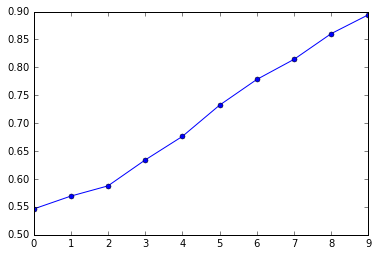

In [118]:
train_means,train_std,test_means,test_std,first2_mean=testRecentNum(0 ,10)